In [1]:
# IMPORTS
import os
import numpy as np
from utils.data import read_stock_history, normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from model.td3.actor import TD3ActorNetwork
from model.td3.critic import TD3CriticNetwork
from model.td3.td3 import TD3
from stock_trading import StockActor, StockCritic, TD3StockActor, TD3StockCritic, obs_normalizer, get_model_path, get_result_path, test_model, get_variable_scope, test_model_multiple
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv, max_drawdown, sharpe, sortino, create_close_dataframe, convert_prices
import tflearn
from stock_trading import test_portfolio_selection, test_portfolio_selection_multiple, plot_weights, plot_portfolio_values, results_table, results_table_row, returns_from_cumulative, test_with_given_weights

print("Imports Complete")







Imports Complete


In [2]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

models = []
model_names = []
framework_lst = ['TD3']
window_length_lst = [3]
maximum_window = max(window_length_lst)
predictor_type_lst = ['lstm']
use_batch_norm = True
log_return = True
technical_indicators_flag = False
load_technical_indicators = True

In [3]:
# Stock History
dataset_name = 'nyse_o'
history, assets, date_list = read_stock_history(filepath='utils/datasets/{}.h5'.format(dataset_name))
history = history[:, :, :4]
nb_classes = len(history) + 1
print("Dataset: {}".format(dataset_name))
print("Assets: {}".format(assets))
print("Stock History Shape: {}".format(history.shape))
print("Full Stock History Date Range: {} -> {}".format(date_list[0], date_list[-1]))

Dataset: nyse_o
Assets: ['ahp', 'alcoa', 'amer_brands', 'arco', 'coke', 'comm_metals', 'dow_chem', 'Dupont', 'espey_manufacturing', 'Exxon', 'fischbach', 'ford', 'ge', 'gm', 'gte', 'gulf', 'hp', 'ibm', 'ingersoll', 'Iroquois', 'jnj', 'kimb-clark', 'kin_ark', 'Kodak', 'lukens', 'mei_corp', 'merck', 'mmm', 'mobil', 'morris', 'p_and_g', 'Pillsbury', 'schlum', 'sears', 'sher_will', 'texaco']
Stock History Shape: (36, 5650, 2)
Full Stock History Date Range: 05/07/1962 -> 31/12/1984


In [4]:
# Training/Testing Date Range
full_length = len(date_list)
train_test_ratio = 6/7
train_start_date = date_list[maximum_window]
train_end_date = date_list[(int)(full_length * train_test_ratio)-1]
test_start_date = date_list[(int)(full_length * train_test_ratio)]
test_end_date = date_list[full_length-2]
print("Training Date Range: {} -> {} ({} Steps)".format(train_start_date, train_end_date, 
                                                    (int)(date_list.index(train_end_date) - date_list.index(train_start_date))))
print("Testing Date Range: {} -> {} ({} Steps)".format(test_start_date, test_end_date, 
                                                    (int)(date_list.index(test_end_date) - date_list.index(test_start_date))))

Training Date Range: 10/07/1962 -> 21/10/1981 (4838 Steps)
Testing Date Range: 22/10/1981 -> 28/12/1984 (806 Steps)


In [5]:
# Generate Technical Indicators
def GenerateTechnicalIndicators(window_length, debug = False):
    if debug:
        print('history.shape: {}'.format(history.shape))

    # Check if just close is fed or full dataset
    if history.shape[2] == 4:
        # Get Close
        history_close = history[:, :, 3]
    elif history.shape[2] == 2:
        # Assume the one sent is the close price
        history_close = history[:, :, 1]

    if debug:
        print('history_close.shape: {}'.format(history_close.shape))

    # Add Technical Indicators to be included in state
    if technical_indicators_flag:
        technical_indicator_history = []

        # Close Price DataFrame for on-line Portfolio Selection
        temp_close_df = create_close_dataframe(history, assets, date_list)
        temp_close_df = convert_prices(temp_close_df, 'raw', True)    
        if debug:
            print('temp_close_df.shape: {}'.format(temp_close_df.shape))

        rmr_moving_average_df = full_rmr_moving_average(temp_close_df, window_length)
        for i in range(len(assets)):
            # Create List
            ti = []
            #ti.append([olmar_moving_average(temp_close_df[assets[i]], window_length)]) # Based on OLMAR
            ti.append([rmr_moving_average_df[assets[i]]]) # Based on RMR

            # Turn to Array
            ti = np.vstack(ti)

            ti_reshaped = []
            for j in range(temp_close_df.shape[0]):
                ti_reshaped.append(ti[:, j])   

            technical_indicator_history.append(ti_reshaped)

        technical_indicator_history = np.array(technical_indicator_history)    
        if debug:
            print('technical_indicators.shape: {}'.format(technical_indicator_history.shape)) 
    else:
        technical_indicator_history = None
        
    return technical_indicator_history

In [6]:
if technical_indicators_flag:
    if load_technical_indicators:
        # Load Technical Indicators dataset
        ti_dict = np.load('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name),allow_pickle='TRUE').item()
    else:
        ti_dict = {}
        for window_length in window_length_lst:
            technical_indicator_history = GenerateTechnicalIndicators(window_length)
            ti_dict[window_length] = technical_indicator_history
        np.save('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name), ti_dict) 

In [7]:
# instantiate environment
for framework in framework_lst:
    for window_length in window_length_lst:
        for predictor_type in predictor_type_lst:
            if technical_indicators_flag:
                name = '{}_{}_window_{}_predictor_{}_rmr-pred'.format(dataset_name, framework, window_length, predictor_type)
            else:
                name = '{}_{}_window_{}_predictor_{}'.format(dataset_name, framework, window_length, predictor_type)
            model_names.append(name)
            tf.reset_default_graph()
            sess = tf.Session()
            tflearn.config.init_training_mode()
            action_dim = [nb_classes]
            if technical_indicators_flag:
                technical_indicator_history = ti_dict[window_length]
                state_dim = [nb_classes, window_length+technical_indicator_history.shape[2]]
            else:
                state_dim = [nb_classes, window_length]

            variable_scope = get_variable_scope(dataset_name, framework, window_length, predictor_type, 
                                                use_batch_norm, technical_indicators_flag)

            with tf.variable_scope(variable_scope):

                if(framework == 'DDPG'):
                    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                       predictor_type, use_batch_norm)
                    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                             learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm)
                    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

                    model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
                    summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

                    ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                                      log_return=log_return, config_file='config/stock.json', 
                                      model_save_path=model_save_path, summary_path=summary_path)
                    ddpg_model.initialize(load_weights=True, verbose=True)
                    models.append(ddpg_model)

                elif(framework == 'TD3'):
                    actor = TD3StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                          predictor_type, use_batch_norm)
                    critic = TD3StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                             learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(),
                             predictor_type=predictor_type, use_batch_norm=use_batch_norm,
                               inp_actions=actor.scaled_out)
                    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

                    model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
                    summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

                    td3_model = TD3(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer, 
                                    log_return=log_return, config_file='config/stock.json', 
                                    model_save_path=model_save_path, summary_path=summary_path)
                    td3_model.initialize(load_weights=True, verbose=True)
                    models.append(td3_model)


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.





INFO:tensorflow:Restoring parameters from weights/nyse_o/TD3/lstm/window_3/batch_norm/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_o_TD3_lstm_window_3_batch_norm/LSTM/nyse_o_TD3_lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_o_TD3_lstm_window_3_batch_norm/LSTM/nyse_o_TD3_lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_o_TD3_lstm_window_3_batch_norm/LSTM/nyse_o_TD3_lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_o_TD3_lstm_

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

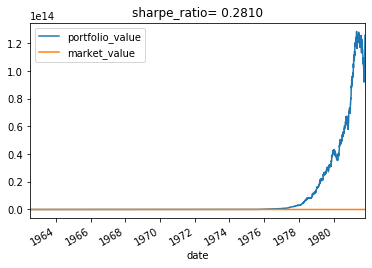

In [8]:
model_weights_list = []

# In-sample Compiled Results
for model in models:
            
    if technical_indicators_flag:
        env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length, 
                                  technical_indicators_flag=technical_indicators_flag, 
                                  technical_indicator_history=ti_dict[window_length])
    else:
        env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length)

    dates, _, _, _, model_weights, _, _, _ = test_model(env, model)
    model_weights_list.append(model_weights)

In [9]:
# OLPS
env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=3, olps=True)

olps_model_names = ['CRP', 'BCRP', 'OLMAR', 'PAMR', 'RMR', 'WMAMR', 'EG', 'ONS', 'UP']
observations_list, in_olps_portfolio_values_list, weights_list, dates = test_portfolio_selection_multiple(env, 
                                                                                                olps_model_names)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


=========CRP=========
len(weights_array): 5650
=========BCRP=========
252.0
len(weights_array): 4839
=========OLMAR=========
len(weights_array): 4839
=========PAMR=========
len(weights_array): 4839
=========RMR=========
len(weights_array): 4839
=========WMAMR=========
len(weights_array): 4839
=========EG=========
len(weights_array): 4839
=========ONS=========
len(weights_array): 4839
=========UP=========
len(weights_array): 4839


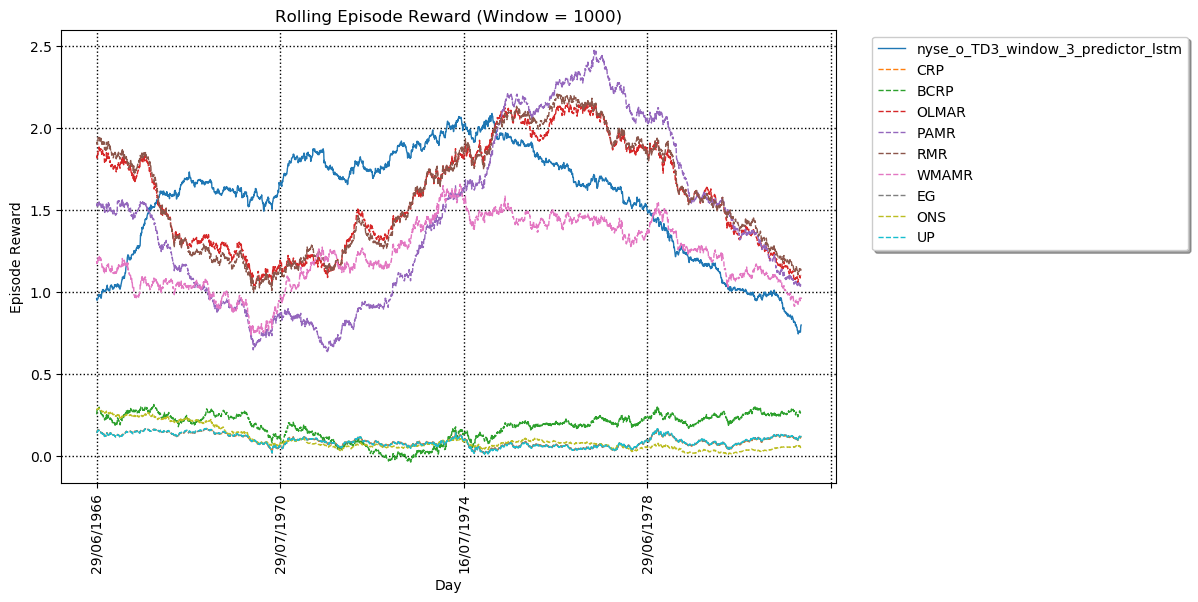

In [10]:
rolling_window = 1000 # Episode Steps
roll_reward_df = pd.DataFrame()
roll_reward_df["Date"] = dates
roll_reward_df.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Episode Reward (Window = {})'.format(rolling_window))
plt.ylabel('Episode Reward')
plt.xlabel('Day')


for i in range(len(model_names)):
    # Rerun to get Result list
    _, _, _, _, reward_list = test_with_given_weights(env, model_weights_list[i])
    roll_reward_df['day_rewards'] = np.append(np.repeat(np.nan, 0), reward_list)
    roll_reward_df[model_names[i]] = roll_reward_df['day_rewards'].rolling(rolling_window).apply(sum, raw=True)
    plt.plot(roll_reward_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
                 linewidth=1)

for i in range(len(olps_model_names)):
    # Rerun to get Result list
    _, _, _, _, reward_list = test_with_given_weights(env, weights_list[i])
    roll_reward_df['day_rewards'] = np.append(np.repeat(np.nan, 0), reward_list)
    roll_reward_df[olps_model_names[i]] = roll_reward_df['day_rewards'].rolling(rolling_window).apply(sum, raw=True)
    plt.plot(roll_reward_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
                 linewidth=1, 
                 linestyle='dashed')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_reward_df.drop('day_rewards', axis=1, inplace=True)

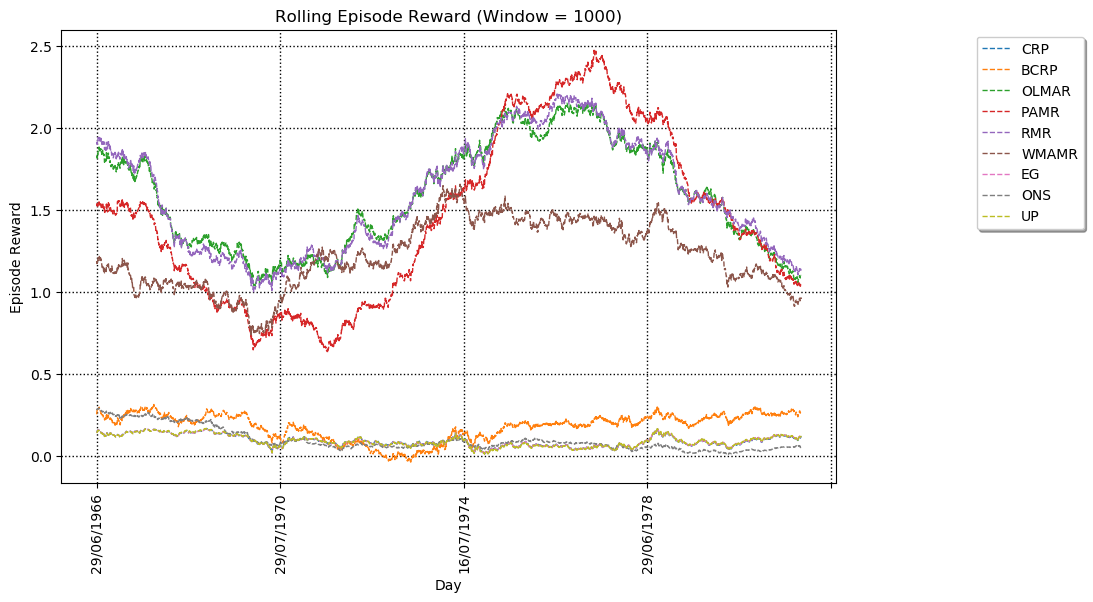

In [11]:
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Episode Reward (Window = {})'.format(rolling_window))
plt.ylabel('Episode Reward')
plt.xlabel('Day')

for i in range(len(olps_model_names)):
    plt.plot(roll_reward_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
                 linewidth=1, 
                 linestyle='dashed')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

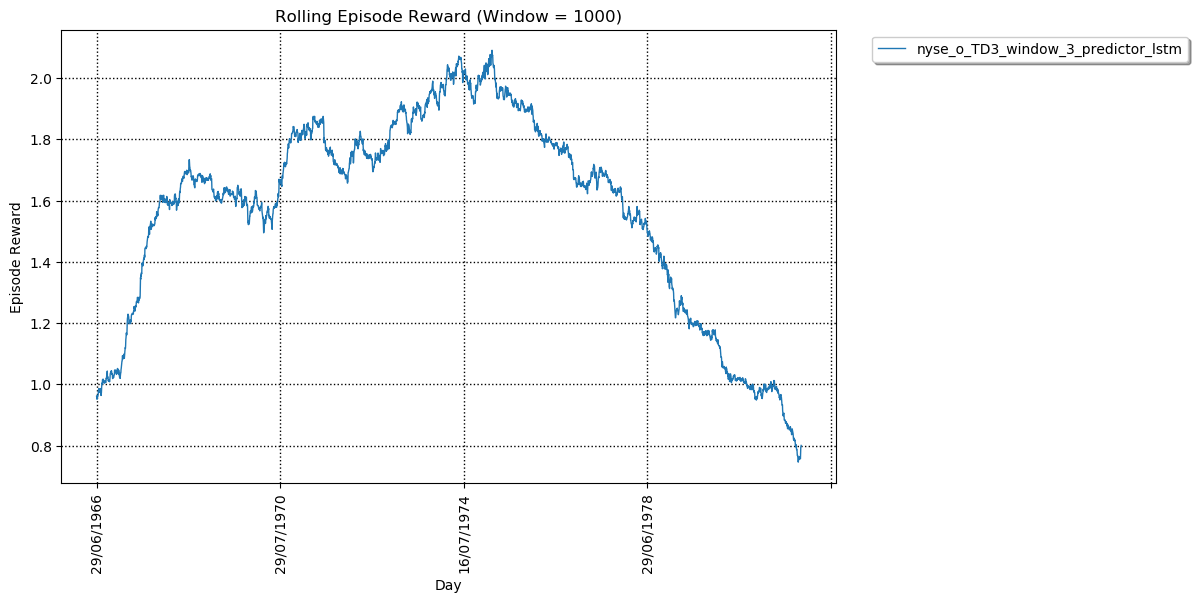

In [12]:
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Episode Reward (Window = {})'.format(rolling_window))
plt.ylabel('Episode Reward')
plt.xlabel('Day')

for i in range(len(model_names)):
    plt.plot(roll_reward_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
                 linewidth=1)

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [13]:
roll_reward_df.tail()

,nyse_o_TD3_window_3_predictor_lstm,CRP,BCRP,OLMAR,PAMR,RMR,WMAMR,EG,ONS,UP
Date,,,,,,,,,,
16/10/1981,0.756965,0.113420,0.266661,1.097325,1.037256,1.129683,0.959467,0.116486,0.056254,0.115681
19/10/1981,0.777065,0.115368,0.268884,1.103176,1.048552,1.135534,0.961079,0.118523,0.053269,0.117906
20/10/1981,0.795892,0.118199,0.271318,1.103176,1.050689,1.135534,0.964684,0.121380,0.055086,0.120811
21/10/1981,0.796463,0.119558,0.277258,1.103621,1.052075,1.143340,0.966686,0.122896,0.053683,0.122114
22/10/1981,0.800647,0.117342,0.273446,1.103141,1.058488,1.143842,0.959252,0.120607,0.051819,0.119968
